In [2]:
!pip install git+https://github.com/uwjunqi/Pytorch-Tensor-Train-Network.git

In [ ]:
%load_ext autoreload
import torch
import torch.nn as nn
import sys
import os
import time

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.callbacks import early_stopping, plot
from tedeous.optimizers.optimizer import Optimizer
from tedeous.device import solver_device

from tc.tc_fc import TTLinear


In [3]:
solver_device('cuda')

domain = Domain()

domain.variable('x', [0, 1], 50)
domain.variable('t', [0, 1], 50)

boundaries = Conditions()

# u(x,0)=1e4*sin^2(x(x-1)/10)
x = domain.variable_dict['x']
func_bnd1 = lambda x: 10 ** 4 * torch.sin((1/10) * x * (x-1)) ** 2
boundaries.dirichlet({'x': [0, 1], 't': 0}, value=func_bnd1(x))

# du/dx (x,0) = 1e3*sin^2(x(x-1)/10)
func_bnd2 = lambda x: 10 ** 3 * torch.sin((1/10) * x * (x-1)) ** 2
bop2 = {
        'du/dt':
            {
                'coeff': 1,
                'du/dt': [1],
                'pow': 1,
                'var': 0
            }
}
boundaries.operator({'x': [0, 1], 't': 0}, operator=bop2, value=func_bnd2(x))

# u(0,t) = u(1,t)
boundaries.periodic([{'x': 0, 't': [0, 1]}, {'x': 1, 't': [0, 1]}])

# du/dt(0,t) = du/dt(1,t)
bop4= {
        'du/dx':
            {
                'coeff': 1,
                'du/dx': [0],
                'pow': 1,
                'var': 0
            }
}
boundaries.periodic([{'x': 0, 't': [0, 1]}, {'x': 1, 't': [0, 1]}], operator=bop4)

equation = Equation()

# wave equation is d2u/dt2-(1/4)*d2u/dx2=0
C = 4
wave_eq = {
    'd2u/dt2':
        {
            'coeff': 1,
            'd2u/dt2': [1, 1],
            'pow': 1
        },
        '-1/C*d2u/dx2':
        {
            'coeff': -1/C,
            'd2u/dx2': [0, 0],
            'pow': 1
        }
}

equation.add(wave_eq)

CUDA is available and used.


In [4]:
net = torch.nn.Sequential(
         torch.nn.Linear(2, 100),
         torch.nn.Tanh(),
         torch.nn.Linear(100, 100),
         torch.nn.Tanh(),
         torch.nn.Linear(100, 100),
         torch.nn.Tanh(),
         torch.nn.Linear(100, 1))

hid = [5, 2, 5, 2]
rank = [1, 3, 3, 3, 1]

tensored_nn = torch.nn.Sequential(
        nn.Linear(2, 100),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        nn.Linear(100, 1))

In [5]:
cb_es = early_stopping.EarlyStopping(eps=1e-6,
                                     no_improvement_patience=500,
                                     info_string_every=500)

cb_plots = plot.Plots(save_every=None, print_every=500)

In [6]:
from tedeous.optimizers import ZO_AdaMM

In [7]:
optim = ZO_AdaMM(tensored_nn.parameters(), len(domain))

In [8]:
optimizer = Optimizer(optim, learning_rate=1e-3)

In [9]:
model = Model(tensored_nn, domain, equation, boundaries)

model.compile("autograd", lambda_operator=1, lambda_bound=1000, h=0.01)

[2024-03-04 16:45:42.431504] initial (min) loss is 7738.28564453125
<bound method OptimizerStep._closure_zo of <tedeous.optimizers.step.OptimizerStep object at 0x000001CF380A1330>>
Step = 0 loss = 7738.285645 normalized loss line= -0.000000x+1.000000. There was 0 stop dings already.


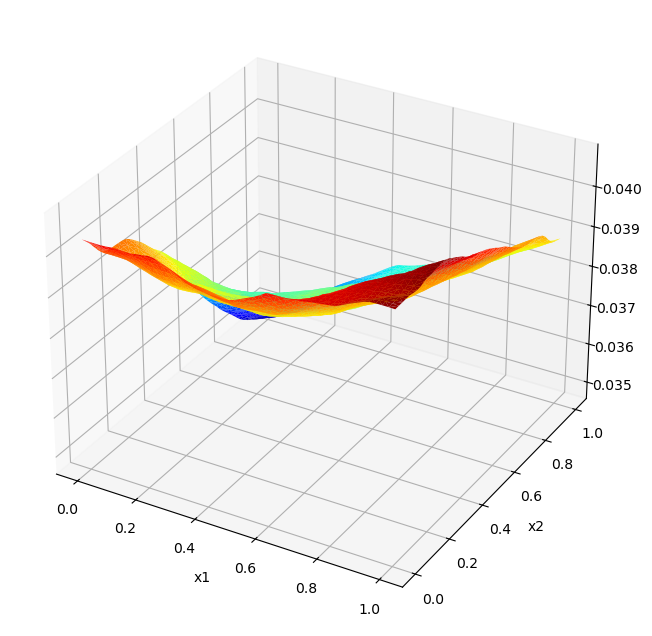

Step = 0 loss = 7738.285645.
Step = 500 loss = 5066.549316 normalized loss line= -0.000553x+1.052976. There was 0 stop dings already.


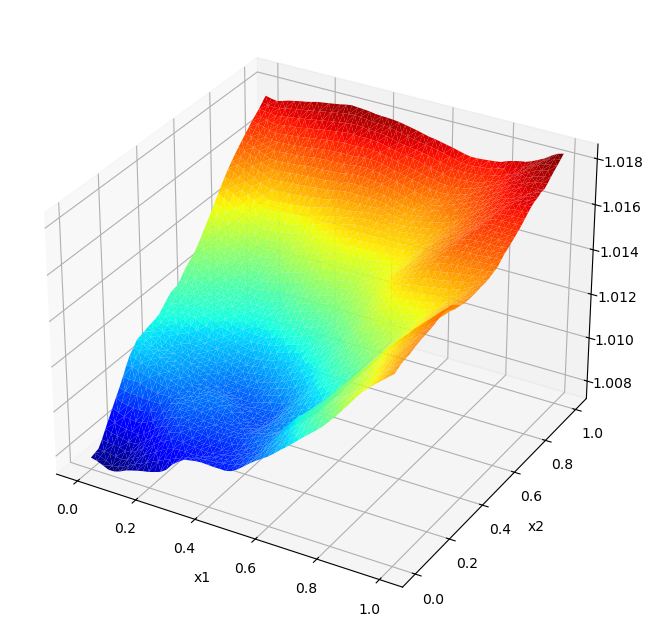

Step = 500 loss = 5066.549316.
Step = 1000 loss = 4081.248047 normalized loss line= -0.000416x+1.039934. There was 0 stop dings already.


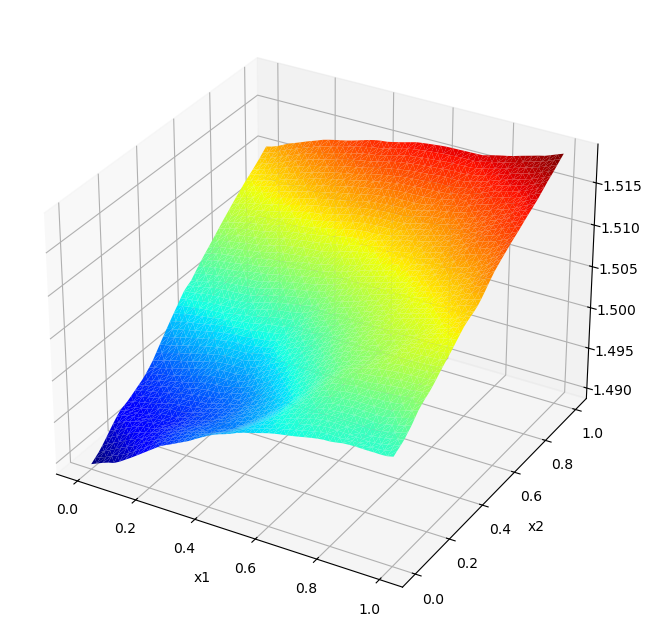

Step = 1000 loss = 4081.248047.
Step = 1500 loss = 3354.261230 normalized loss line= -0.000434x+1.041549. There was 0 stop dings already.


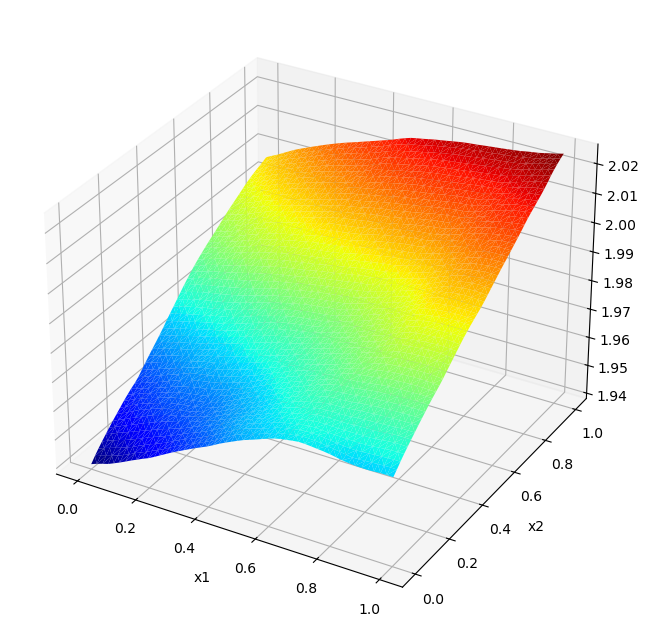

Step = 1500 loss = 3354.261230.
Step = 2000 loss = 2714.169678 normalized loss line= -0.000415x+1.039327. There was 0 stop dings already.


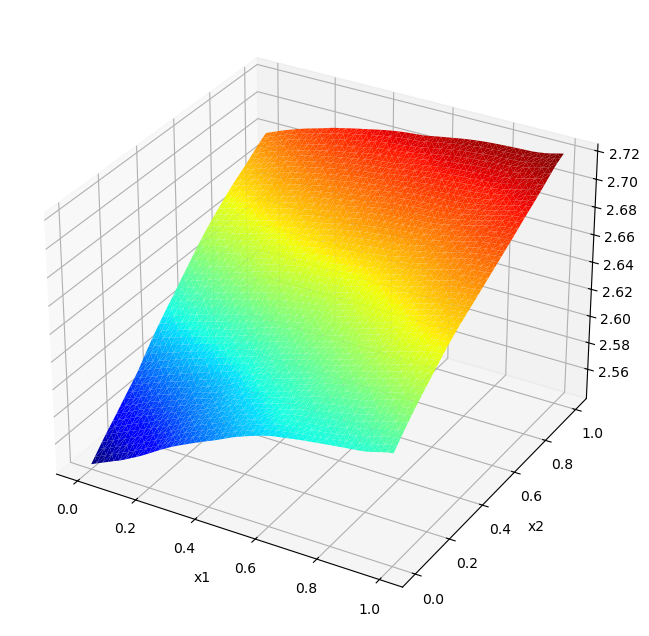

Step = 2000 loss = 2714.169678.
Step = 2500 loss = 2471.541016 normalized loss line= -0.000059x+1.005252. There was 0 stop dings already.


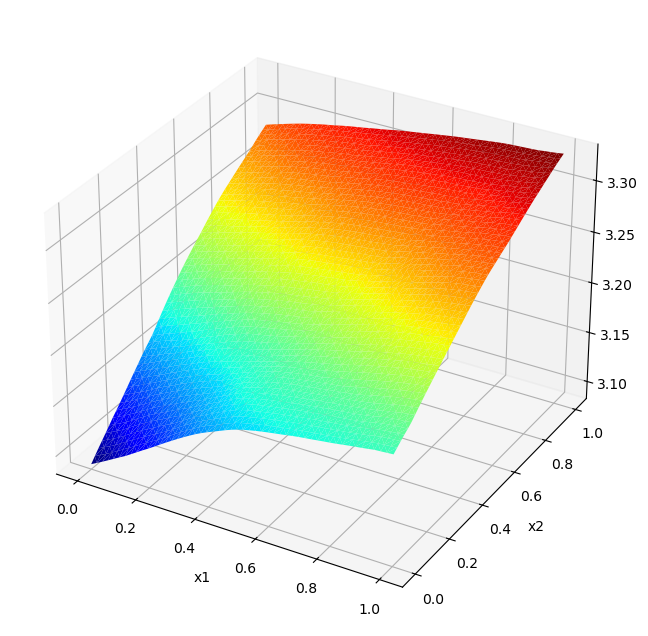

Step = 2500 loss = 2471.541016.
Step = 3000 loss = 2449.380127 normalized loss line= -0.000020x+1.002002. There was 0 stop dings already.


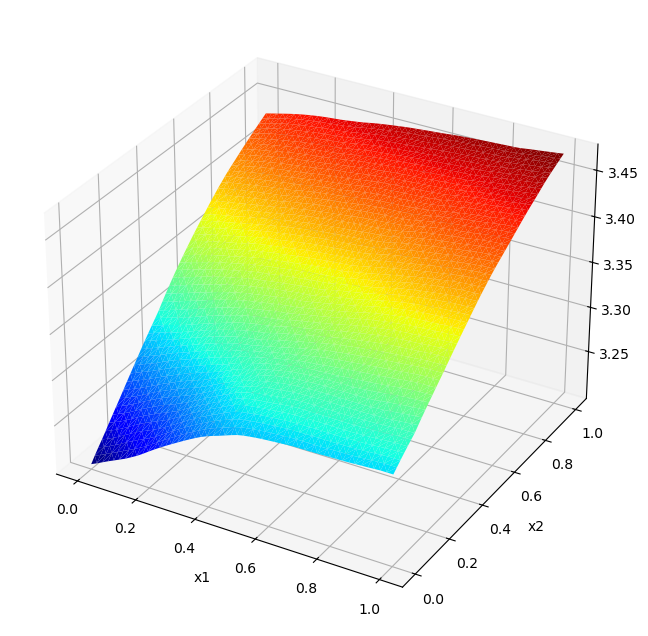

Step = 3000 loss = 2449.380127.
Step = 3500 loss = 2436.435791 normalized loss line= -0.000014x+1.001336. There was 0 stop dings already.


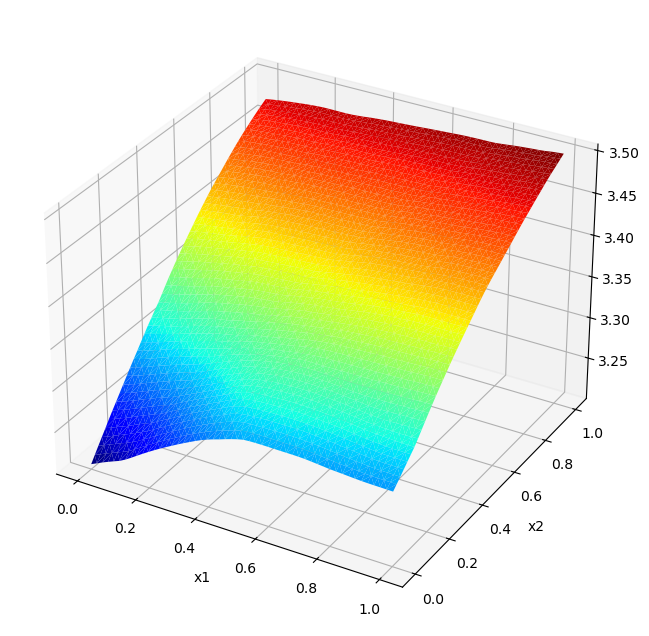

Step = 3500 loss = 2436.435791.
Step = 4000 loss = 2426.184326 normalized loss line= -0.000011x+1.001278. There was 0 stop dings already.


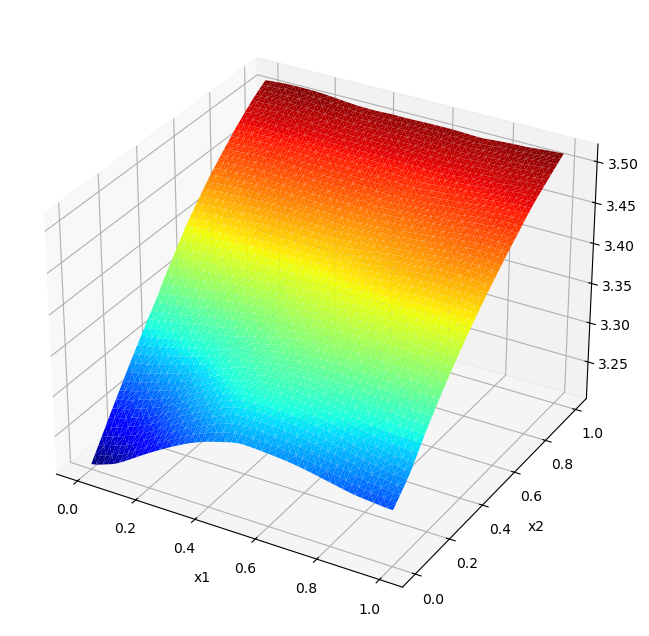

Step = 4000 loss = 2426.184326.
Step = 4500 loss = 2409.141846 normalized loss line= -0.000026x+1.002383. There was 0 stop dings already.


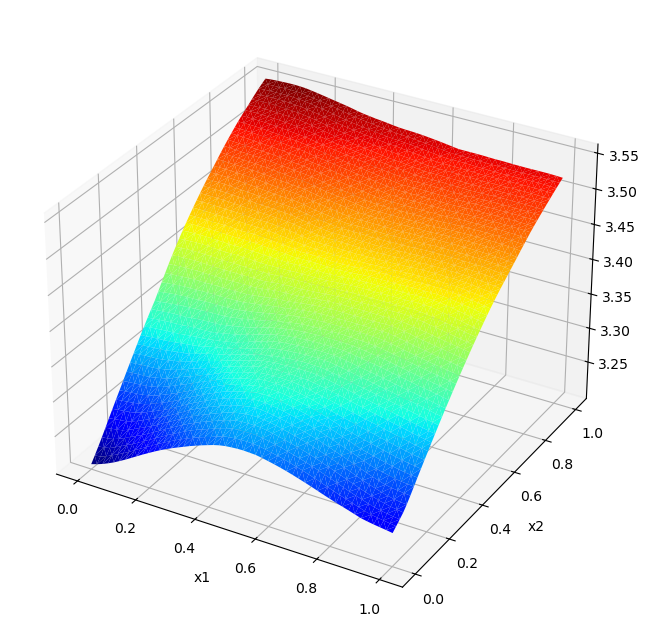

Step = 4500 loss = 2409.141846.


AssertionError: 

In [10]:
model.train(optimizer=optimizer, epochs=5e6, save_model=False,  print_every=500,verbose=1, callbacks=[cb_es, cb_plots])